## Add the region of company from postal code from company_register

In [7]:
import pandas as pd

In [8]:
# dtype of all columns are string
df = pd.read_csv('./data/company_register/full_prh_data.csv', sep=';', dtype={'business_line_code': str, 'postal_post_code': str})
df = df[['company_name', 'business_line_code', 'postal_post_code']]

post_code_region_mapping = pd.read_csv('./data/region_city_data/post_code_to_region.csv', dtype={'post_code': str})
post_code_region_mapping = post_code_region_mapping.set_index('post_code').to_dict()['region']

df['postal_region'] = df['postal_post_code'].map(post_code_region_mapping)

In [9]:
df['postal_post_code'].isna().sum()

3214

In [10]:
df['postal_region'].isna().sum()

23190

In [11]:
df.dropna(inplace=True)

In [12]:
df

,company_name,business_line_code,postal_post_code,postal_region
0,Profiteam Oy,79900,00500,Uusimaa
1,Ruskalinna Oy,79900,95700,Lappi
2,Saaga Safarit Oy Ukkohalla,79900,90100,Pohjois-Pohjanmaa
3,Oy SaariTours Ab,79120,10940,Uusimaa
4,Nordic JD Oy,79120,02620,Uusimaa
...,...,...,...,...
330352,Keijo Siikaluoma Oy,88109,90130,Pohjois-Pohjanmaa
330353,Stella Kotipalvelut Oy,88991,00380,Uusimaa
330354,Norlandia Päiväkodit Oy,88911,02600,Uusimaa
330355,Palvelukoti Länsituuli Oy,88101,00300,Uusimaa


In [13]:
df.to_csv('./data/company_register/full_prh_data_with_region.csv', index=False)

## Process data mapping from municipality -> region

In [34]:
import pandas as pd

In [42]:
df = pd.read_csv('./data/region_city_data/mapper_updated.csv', sep=';')

# strip the whitespace from the all columns that is string
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# df.columns = ['Name of Municipality in Finnish', 'Number of municipality','Code of region', 'Name of region in Finnish']

# remove last column
df = df.iloc[:, :-1]

In [44]:
df.to_csv('./data/region_city_data/municipality_region_map.csv', index=False)

## Handy code to convert NACE Code

In [ ]:
# create a mapping from nace code to nace class. Eg: 79 -> N
nace_class = pd.read_excel("./data/nace_codes/nace_classification.xlsx")
nace_class.columns = nace_class.iloc[0]
nace_class = nace_class.iloc[1:]
nace_class = nace_class[nace_class['Level'] == '2'] 
nace_class = nace_class[['NACE Rev. 2', 'Section']]
nace_class.columns = ['NACE_Code', 'Section']
nace_class.reset_index(drop=True, inplace=True)

# # convert nace_class to dictionary
# nace_class_dict = nace_class.set_index('NACE Rev. 2').to_dict()['Section']

## Break down tax data with company count - Experiment

In [1]:
import pandas as pd
import numpy as np
import requests

In [113]:
# Function to fetch business line from PRH API
def fetch_business_line_prh(row):
    business_id = row['Business_ID']
    index = row.name
    url = f'https://avoindata.prh.fi/bis/v1/{business_id}'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        business_lines = data['results'][0].get('businessLines', [])[0].get('code', np.nan)
        return business_lines
    else:
        print(f'Failed to fetch data for business ID: {business_id}, index: {index}, status code: {response.status_code}')
        return np.nan


In [2]:
# create a mapping from business_id to industry 
df = pd.read_csv('./data/combined/company_nace_region.csv', dtype={'postal_post_code': str, 'business_line_code': str})
df.dropna(inplace=True)

# convert business_id_industry_map to dict
business_id_industry_map = df[['business_id', 'Section']]
business_id_industry_map = business_id_industry_map.set_index('business_id').to_dict()['Section']

# load municipality region mapping
municipality_region_map = pd.read_csv('./data/region_city_data/municipality_region_map.csv')
municipality_region_map = municipality_region_map[['Name of Municipality in Finnish', 'Number of municipality','Code of region', 'Name of region in Finnish']]
mapper = municipality_region_map[['Number of municipality', 'Code of region']]
mapper = mapper.set_index('Number of municipality').to_dict()['Code of region']

In [116]:
# load tax data from a sample year
tax_data = pd.read_csv('./data/tax_data/tax_2021.csv')

# strip all whitespace from Tax_Region column
tax_data['Tax_Region'] = tax_data['Tax_Region'].str.strip()

tax_data['Municipality_Code'] = tax_data['Tax_Region'].str.split(' ').str[0].astype(int)
tax_data['Municipality'] = tax_data['Tax_Region'].str.split(' ').str[1].astype(str)

tax_data

,Year,Business_ID,Name,Tax_Region,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax,Municipality_Code,Municipality
0,2021,3133207-5,Med-Man Oy,444 Lohja,"19538,10","3907,62","1079,90","0,00","2827,72",444,Lohja
1,2021,3132728-4,Kultalasi Oy,536 Nokia,"0,00","0,00","0,00","0,00","0,00",536,Nokia
2,2021,1071985-2,FM Timber Oy,601 Pihtipudas,"17851929,22","3573385,84","3603000,00","29614,16","0,00",601,Pihtipudas
3,2021,3124647-6,A La Kaappi Oy,049 Espoo,"215804,86","43881,29","49738,68","5857,39","0,00",49,Espoo
4,2021,3142618-6,Tuonoinii Invest Oy,734 Salo,"0,00","0,00","0,00","0,00","0,00",734,Salo
...,...,...,...,...,...,...,...,...,...,...,...
342686,2021,2769288-7,Eran Oy,050 Eura,"105356,40","21405,03","21405,03","0,00","0,00",50,Eura
342687,2021,2751387-7,Taljan Hallinta Oy,091 Helsinki,"2665,81","533,16","1110,86","577,70","0,00",91,Helsinki
342688,2021,2766401-8,Trimmi Inspire Oy,837 Tampere,"0,00","0,00","0,00","0,00","0,00",837,Tampere
342689,2021,2741109-6,Ompelimo Taito-Ommel Oy,091 Helsinki,"3934,83","786,97","678,48","0,00","108,49",91,Helsinki


In [117]:
# merge tax data with municipality_region_map by municipality code
df = pd.merge(tax_data, municipality_region_map, left_on='Municipality_Code', right_on='Number of municipality', how='left')
df.drop(columns=['Number of municipality', 'Name of Municipality in Finnish'], inplace=True)
df['Section'] = df['Business_ID'].map(business_id_industry_map)

# convert Municipality_Code to string, and prefix with 0 if string length is less than 3
df['Municipality_Code'] = df['Municipality_Code'].astype(str).apply(lambda x: x.zfill(3))

# convert tax data to numeric values
for col in ['Tax_Revenue', 'Total_Amount_Paid', 'Tax_Advance', 'Tax_Return', 'Residual_Tax']:
    df[col] = df[col].str.replace(',', '.').astype(float)

df

,Year,Business_ID,Name,Tax_Region,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax,Municipality_Code,Municipality,Code of region,Name of region in Finnish,Section
0,2021,3133207-5,Med-Man Oy,444 Lohja,19538.10,3907.62,1079.90,0.00,2827.72,444,Lohja,1.0,Uusimaa,Q
1,2021,3132728-4,Kultalasi Oy,536 Nokia,0.00,0.00,0.00,0.00,0.00,536,Nokia,6.0,Pirkanmaa,G
2,2021,1071985-2,FM Timber Oy,601 Pihtipudas,17851929.22,3573385.84,3603000.00,29614.16,0.00,601,Pihtipudas,13.0,Keski-Suomi,C
3,2021,3124647-6,A La Kaappi Oy,049 Espoo,215804.86,43881.29,49738.68,5857.39,0.00,049,Espoo,1.0,Uusimaa,G
4,2021,3142618-6,Tuonoinii Invest Oy,734 Salo,0.00,0.00,0.00,0.00,0.00,734,Salo,2.0,Varsinais-Suomi,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342686,2021,2769288-7,Eran Oy,050 Eura,105356.40,21405.03,21405.03,0.00,0.00,050,Eura,4.0,Satakunta,M
342687,2021,2751387-7,Taljan Hallinta Oy,091 Helsinki,2665.81,533.16,1110.86,577.70,0.00,091,Helsinki,1.0,Uusimaa,L
342688,2021,2766401-8,Trimmi Inspire Oy,837 Tampere,0.00,0.00,0.00,0.00,0.00,837,Tampere,6.0,Pirkanmaa,M
342689,2021,2741109-6,Ompelimo Taito-Ommel Oy,091 Helsinki,3934.83,786.97,678.48,0.00,108.49,091,Helsinki,1.0,Uusimaa,C


In [118]:
df.isna().sum()

Year                              0
Business_ID                       0
Name                              0
Tax_Region                        0
Tax_Revenue                       0
Total_Amount_Paid                 0
Tax_Advance                       0
Tax_Return                        0
Residual_Tax                      0
Municipality_Code                 0
Municipality                      0
Code of region                 9048
Name of region in Finnish      9048
Section                      119187
dtype: int64

In [120]:
# Filter the DataFrame to include only rows where 'Section' is NaN
filtered_df = df[df['Section'].isna()]

# Apply your function to the filtered DataFrame
result = filtered_df.apply(lambda x: fetch_business_line_prh(x), axis=1)

# Update the original DataFrame with the new values
df.loc[filtered_df.index, 'Section'] = result
df

Failed to fetch data for business ID: 3141700-1, index: 5, status code: 404
Failed to fetch data for business ID: 2023813-9, index: 6, status code: 404
Failed to fetch data for business ID: 0965448-1, index: 32, status code: 404
Failed to fetch data for business ID: 0397650-0, index: 38, status code: 404
Failed to fetch data for business ID: 3132963-4, index: 43, status code: 404
Failed to fetch data for business ID: 3132219-2, index: 50, status code: 404
Failed to fetch data for business ID: 3118300-6, index: 67, status code: 404
Failed to fetch data for business ID: 1077214-3, index: 74, status code: 404
Failed to fetch data for business ID: 2468434-7, index: 78, status code: 404
Failed to fetch data for business ID: 0832853-7, index: 104, status code: 404
Failed to fetch data for business ID: 3139199-9, index: 124, status code: 404
Failed to fetch data for business ID: 3128040-4, index: 146, status code: 404
Failed to fetch data for business ID: 3120270-5, index: 151, status code: 4

IndexError: list index out of range

## Full company-tax data

In [242]:
def get_business_id_industry_map() -> dict:
    '''
    Helper function that returns the dictionary of Business_ID
    to Section. Eg: '3133207-5' -> 'Q'

    The dictionary is created from two sources:
    1. ./data/combined/company_nace_region.csv: This file contains
        the information of companies in 2022, including their
        Business_ID and Section. 
    2. ./data/tax_data/additional_business_line.csv: This file contains
        the direct mapping of Business_ID to Section. This file is created
        by fetching the business line from PRH API for the Business_IDs with
        unknown Section which is not all covered by the first file.
    '''
    # get data from source 1
    business_id_industry_map = pd.read_csv('./data/combined/company_nace_region.csv', dtype={'postal_post_code': str, 'business_line_code': str})
    business_id_industry_map = business_id_industry_map[['business_id', 'Section']]
    business_id_industry_map = business_id_industry_map.set_index('business_id').to_dict()['Section']

    # create a mapping from nace code to nace class. Eg: 79 -> N
    nace_class = pd.read_excel("./data/nace_codes/nace_classification.xlsx")
    nace_class.columns = nace_class.iloc[0]
    nace_class = nace_class.iloc[1:]
    nace_class = nace_class[nace_class['Level'] == '2'] 
    nace_class = nace_class[['NACE Rev. 2', 'Section']]
    nace_class.reset_index(drop=True, inplace=True)
    nace_class_dict = nace_class.set_index('NACE Rev. 2').to_dict()['Section']

    # get data from source 2
    additional_business_line = pd.read_csv('./data/tax_data/fill_business_line/additional_business_line.csv', dtype={'Business_ID': str, 'business_line_code': str})
    additional_business_line['Section_Code'] = additional_business_line['business_line_code'].str[:2]
    additional_business_line['Section'] = additional_business_line['Section_Code'].map(nace_class_dict)
    additional_map = additional_business_line.set_index('Business_ID').to_dict()['Section']

    return business_id_industry_map | additional_map


def tax_with_region_and_industry(year: int):
# Function to fill company data in the tax data
    supported_year = np.arange(2011, 2022)
    if year not in supported_year:
        print(f'Year {year} is not supported. Please choose a year between {supported_year.min()} - {supported_year.max()}')
        return None

    # create a mapping from business_id to industry
    business_id_industry_map = get_business_id_industry_map()

    # load municipality region mapping
    municipality_region_map = pd.read_csv('./data/region_city_data/municipality_region_map.csv')
    municipality_region_map = municipality_region_map[['Name of Municipality in Finnish', 'Number of municipality','Code of region', 'Name of region in Finnish']]

    # load tax data from a sample year
    tax_data = pd.read_csv(f'./data/tax_data/tax_{year}.csv')
    if year == 2015: # special case for year 2015
        tax_data['Municipality_Code'] = tax_data['Tax_Region']
    else:
        tax_data['Tax_Region'] = tax_data['Tax_Region'].str.strip() # strip all whitespace from Tax_Region column
        tax_data['Municipality_Code'] = tax_data['Tax_Region'].str.split(' ').str[0].astype(int)
        tax_data['Municipality'] = tax_data['Tax_Region'].str.split(' ').str[1].astype(str)

    # merge tax data with municipality_region_map by municipality code
    df = pd.merge(tax_data, municipality_region_map, left_on='Municipality_Code', right_on='Number of municipality', how='left')
    df['Municipality'] = df['Name of region in Finnish']
    df.drop(columns=['Number of municipality', 'Name of Municipality in Finnish'], inplace=True)
    df['Section'] = df['Business_ID'].map(business_id_industry_map)

    # convert Municipality_Code to string, and prefix with 0 if string length is less than 3
    df['Municipality_Code'] = df['Municipality_Code'].astype(str).apply(lambda x: x.zfill(3))

    # convert tax data to numeric values
    for col in ['Tax_Revenue', 'Total_Amount_Paid', 'Tax_Advance', 'Tax_Return', 'Residual_Tax']:
        df[col] = df[col].str.replace(',', '.').astype(float)

    return df

In [217]:
df = tax_with_region_and_industry(2021)

In [218]:
df

,Year,Business_ID,Name,Tax_Region,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax,Municipality_Code,Municipality,Code of region,Name of region in Finnish,Section
0,2021,3133207-5,Med-Man Oy,444 Lohja,19538.10,3907.62,1079.90,0.00,2827.72,444,Uusimaa,1.0,Uusimaa,Q
1,2021,3132728-4,Kultalasi Oy,536 Nokia,0.00,0.00,0.00,0.00,0.00,536,Pirkanmaa,6.0,Pirkanmaa,G
2,2021,1071985-2,FM Timber Oy,601 Pihtipudas,17851929.22,3573385.84,3603000.00,29614.16,0.00,601,Keski-Suomi,13.0,Keski-Suomi,C
3,2021,3124647-6,A La Kaappi Oy,049 Espoo,215804.86,43881.29,49738.68,5857.39,0.00,049,Uusimaa,1.0,Uusimaa,G
4,2021,3142618-6,Tuonoinii Invest Oy,734 Salo,0.00,0.00,0.00,0.00,0.00,734,Varsinais-Suomi,2.0,Varsinais-Suomi,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342686,2021,2769288-7,Eran Oy,050 Eura,105356.40,21405.03,21405.03,0.00,0.00,050,Satakunta,4.0,Satakunta,M
342687,2021,2751387-7,Taljan Hallinta Oy,091 Helsinki,2665.81,533.16,1110.86,577.70,0.00,091,Uusimaa,1.0,Uusimaa,L
342688,2021,2766401-8,Trimmi Inspire Oy,837 Tampere,0.00,0.00,0.00,0.00,0.00,837,Pirkanmaa,6.0,Pirkanmaa,M
342689,2021,2741109-6,Ompelimo Taito-Ommel Oy,091 Helsinki,3934.83,786.97,678.48,0.00,108.49,091,Uusimaa,1.0,Uusimaa,C


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342691 entries, 0 to 342690
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       342691 non-null  int64  
 1   Business_ID                342691 non-null  object 
 2   Name                       342691 non-null  object 
 3   Tax_Region                 342691 non-null  object 
 4   Tax_Revenue                342691 non-null  float64
 5   Total_Amount_Paid          342691 non-null  float64
 6   Tax_Advance                342691 non-null  float64
 7   Tax_Return                 342691 non-null  float64
 8   Residual_Tax               342691 non-null  float64
 9   Municipality_Code          342691 non-null  object 
 10  Municipality               333643 non-null  object 
 11  Code of region             333643 non-null  float64
 12  Name of region in Finnish  333643 non-null  object 
 13  Section                    25

In [220]:
df.isna().sum()

Year                             0
Business_ID                      0
Name                             0
Tax_Region                       0
Tax_Revenue                      0
Total_Amount_Paid                0
Tax_Advance                      0
Tax_Return                       0
Residual_Tax                     0
Municipality_Code                0
Municipality                  9048
Code of region                9048
Name of region in Finnish     9048
Section                      92225
dtype: int64

In [243]:
# create a for loop to iterate over all years
# use the function and concat all dataframes
years = np.arange(2011, 2022)

dfs = [] # Initialize an empty list to store the dataframes

# Iterate through each year and get the dataframe for that year
for year in years:
    df = tax_with_region_and_industry(year)
    if df is not None:
        dfs.append(df)

# Concatenate all the dataframes into a single big dataframe
final_df = pd.concat(dfs, ignore_index=True)
final_df

,Year,Business_ID,Name,Tax_Region,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax,Municipality_Code,Municipality,Code of region,Name of region in Finnish,Section
0,2011,0568703-2,Brändö Lax Ab,035 BRÄNDÖ,857376.69,222917.94,222913.97,0.00,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,A
1,2011,0841712-6,Norrfjärden Ab,035 BRÄNDÖ,0.00,0.00,0.00,0.00,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,K
2,2011,0144666-1,Brändö Andelshandel,035 BRÄNDÖ,0.00,-15.66,5369.70,5385.36,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,G
3,2011,0144668-8,Jurmo Andelshandel,035 BRÄNDÖ,0.00,300.00,0.00,0.00,300.00,035,Ahvenanmaa,21.0,Ahvenanmaa,G
4,2011,0200418-7,Lappo Handelslag,035 BRÄNDÖ,0.00,0.00,0.00,0.00,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622762,2021,2769288-7,Eran Oy,050 Eura,105356.40,21405.03,21405.03,0.00,0.00,050,Satakunta,4.0,Satakunta,M
3622763,2021,2751387-7,Taljan Hallinta Oy,091 Helsinki,2665.81,533.16,1110.86,577.70,0.00,091,Uusimaa,1.0,Uusimaa,L
3622764,2021,2766401-8,Trimmi Inspire Oy,837 Tampere,0.00,0.00,0.00,0.00,0.00,837,Pirkanmaa,6.0,Pirkanmaa,M
3622765,2021,2741109-6,Ompelimo Taito-Ommel Oy,091 Helsinki,3934.83,786.97,678.48,0.00,108.49,091,Uusimaa,1.0,Uusimaa,C


## Aggregate the data => tax data time series 

In [244]:
final_df

,Year,Business_ID,Name,Tax_Region,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax,Municipality_Code,Municipality,Code of region,Name of region in Finnish,Section
0,2011,0568703-2,Brändö Lax Ab,035 BRÄNDÖ,857376.69,222917.94,222913.97,0.00,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,A
1,2011,0841712-6,Norrfjärden Ab,035 BRÄNDÖ,0.00,0.00,0.00,0.00,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,K
2,2011,0144666-1,Brändö Andelshandel,035 BRÄNDÖ,0.00,-15.66,5369.70,5385.36,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,G
3,2011,0144668-8,Jurmo Andelshandel,035 BRÄNDÖ,0.00,300.00,0.00,0.00,300.00,035,Ahvenanmaa,21.0,Ahvenanmaa,G
4,2011,0200418-7,Lappo Handelslag,035 BRÄNDÖ,0.00,0.00,0.00,0.00,0.00,035,Ahvenanmaa,21.0,Ahvenanmaa,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622762,2021,2769288-7,Eran Oy,050 Eura,105356.40,21405.03,21405.03,0.00,0.00,050,Satakunta,4.0,Satakunta,M
3622763,2021,2751387-7,Taljan Hallinta Oy,091 Helsinki,2665.81,533.16,1110.86,577.70,0.00,091,Uusimaa,1.0,Uusimaa,L
3622764,2021,2766401-8,Trimmi Inspire Oy,837 Tampere,0.00,0.00,0.00,0.00,0.00,837,Pirkanmaa,6.0,Pirkanmaa,M
3622765,2021,2741109-6,Ompelimo Taito-Ommel Oy,091 Helsinki,3934.83,786.97,678.48,0.00,108.49,091,Uusimaa,1.0,Uusimaa,C


### Show tax data time series by region

In [224]:
# TODO: create two functions
# 1. given a region, show all tax time series for that region (tax revenue, tax advance, tax return, residual tax)
# 2. given a metric (tax revenue, tax advance, tax return, residual tax), show tax time series of all regions for that metric

''' 
function(region = 1, metric = 'Tax_Revenue'):
  if only region:
    show all metrics for that region (tax revenue, tax advance, tax return, residual tax)
  if only metric:
    show tax time series of all regions for that metric
  if both:
    show that metric for that region as a single time series
'''

df = final_df.copy()
df.drop(columns=['Business_ID', 'Name', 'Tax_Region', 'Municipality_Code', 'Municipality', 'Section'], inplace=True)
df

,Year,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax,Code of region,Name of region in Finnish
0,2011,857376.69,222917.94,222913.97,0.00,0.00,21.0,Ahvenanmaa
1,2011,0.00,0.00,0.00,0.00,0.00,21.0,Ahvenanmaa
2,2011,0.00,-15.66,5369.70,5385.36,0.00,21.0,Ahvenanmaa
3,2011,0.00,300.00,0.00,0.00,300.00,21.0,Ahvenanmaa
4,2011,0.00,0.00,0.00,0.00,0.00,21.0,Ahvenanmaa
...,...,...,...,...,...,...,...,...
3622762,2021,105356.40,21405.03,21405.03,0.00,0.00,4.0,Satakunta
3622763,2021,2665.81,533.16,1110.86,577.70,0.00,1.0,Uusimaa
3622764,2021,0.00,0.00,0.00,0.00,0.00,6.0,Pirkanmaa
3622765,2021,3934.83,786.97,678.48,0.00,108.49,1.0,Uusimaa


In [225]:
# show the tax data of the year by region
tax_by_region = df.groupby(['Year', 'Code of region', 'Name of region in Finnish']).sum().reset_index()
tax_by_region

,Year,Code of region,Name of region in Finnish,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax
0,2011,1.0,Uusimaa,1.252161e+10,2.990787e+09,3.033070e+09,2.585924e+08,2.162991e+08
1,2011,2.0,Varsinais-Suomi,1.255366e+09,3.268763e+08,3.401487e+08,3.467586e+07,2.140026e+07
2,2011,4.0,Satakunta,6.003387e+08,1.564448e+08,1.449104e+08,8.010156e+06,1.954338e+07
3,2011,5.0,Kanta-Häme,2.717305e+08,7.062990e+07,7.040785e+07,5.243800e+06,5.464705e+06
4,2011,6.0,Pirkanmaa,9.892196e+08,2.574671e+08,2.490118e+08,1.675099e+07,2.520312e+07
...,...,...,...,...,...,...,...,...
204,2021,16.0,Keski-Pohjanmaa,2.387531e+08,4.807922e+07,4.780411e+07,6.184657e+06,6.459658e+06
205,2021,17.0,Pohjois-Pohjanmaa,1.320996e+09,2.671685e+08,2.429593e+08,2.535260e+07,4.956151e+07
206,2021,18.0,Kainuu,1.366941e+08,2.774196e+07,2.596245e+07,2.368770e+06,4.148213e+06
207,2021,19.0,Lappi,6.339444e+08,1.288038e+08,1.010312e+08,8.401493e+06,3.617132e+07


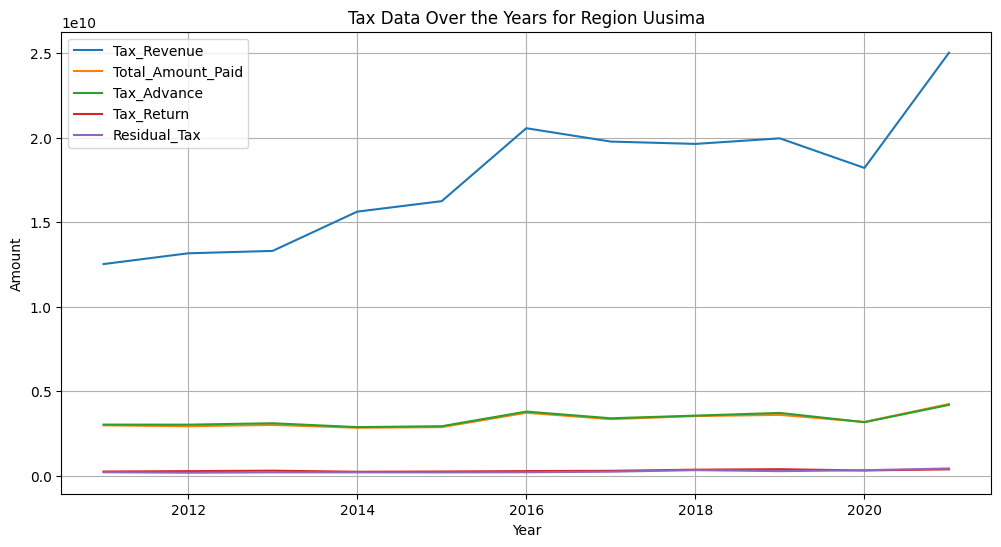

In [226]:
'''
Plot show that tax revenue is the most important metric over the tax data
'''
import matplotlib.pyplot as plt
import pandas as pd

# Filter the data for the region you are interested in (1.0 Uusima)
region_data = tax_by_region[tax_by_region['Code of region'] == 1.0]

# Extract the years and tax-related columns for plotting
years = region_data['Year']
tax_columns = ['Tax_Revenue', 'Total_Amount_Paid', 'Tax_Advance', 'Tax_Return', 'Residual_Tax']

# Create a line plot for each tax column
plt.figure(figsize=(12, 6))
for column in tax_columns:
    plt.plot(years, region_data[column], label=column)

plt.title('Tax Data Over the Years for Region Uusima')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()


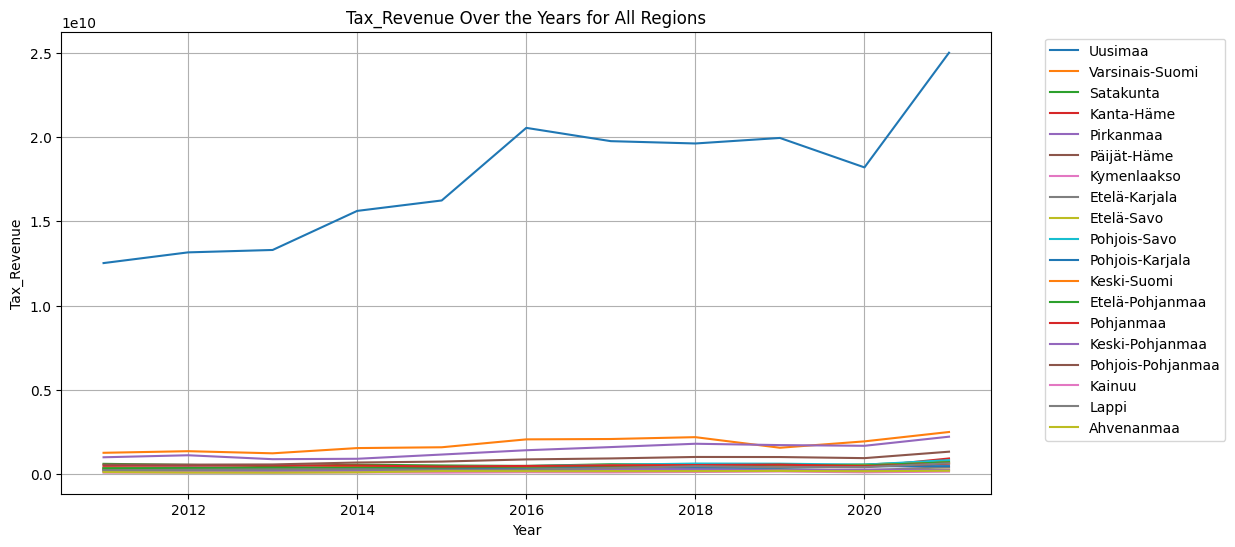

In [227]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the unique regions in the dataset
regions = tax_by_region['Name of region in Finnish'].unique()

# Create a line plot for each region's Tax_Revenue
plt.figure(figsize=(12, 6))
for region in regions:
    region_data = tax_by_region[tax_by_region['Name of region in Finnish'] == region]
    plt.plot(region_data['Year'], region_data['Tax_Revenue'], label=region)

plt.title('Tax_Revenue Over the Years for All Regions')
plt.xlabel('Year')
plt.ylabel('Tax_Revenue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.grid(True)
plt.show()


In [228]:
import pandas as pd
import plotly.express as px

# Assuming you have already loaded your data into a dataframe, let's call it 'big_dataframe'

# Create an interactive line plot using Plotly Express
fig = px.line(tax_by_region, x='Year', y='Tax_Revenue', color='Name of region in Finnish',
              title='Total Tax Revenue Over the Years for 19 Regions',
              labels={'Tax_Revenue': 'Tax Revenue', 'Year': 'Year'},
              width=800, height=500)

# Customize the layout (optional)
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Tax Revenue',
    legend_title='Region',
)

# Show the interactive plot
fig.show()


### Handling missing business line

In [101]:
df = final_df.copy()
df.isna().sum()

Year                               0
Business_ID                        0
Name                               0
Tax_Region                         0
Tax_Revenue                        0
Total_Amount_Paid                  0
Tax_Advance                        0
Tax_Return                         0
Residual_Tax                       0
Municipality_Code                  0
Municipality                   61821
Code of region                 61821
Name of region in Finnish      61821
Section                      1830720
dtype: int64

In [109]:
missing = df[df['Section'].isna()].copy().reset_index(drop=True)

In [119]:
ids = missing['Business_ID'].value_counts().sort_values(ascending=False).index.tolist()

In [145]:
missing_ids = missing['Business_ID'].value_counts()

# show index of missing_ids that has more than 1 missing value
major = missing_ids[missing_ids > 10].index.tolist()
len(major)

78393

In [190]:
code = np.load('./data/tax_data/fill_business_line/iteration_13000.npy')
code[-100:]

array(['-1', '68209', '-1', '64990', '-1', '-1', '-1', '-1', '47301',
       '-1', '-1', '-1', '-1', '-1', '-1', '27510', '-1', '28290', '-1',
       '-1', '-1', '-1', '-1', '-1', '87301', '87202', '-1', '68320',
       '-1', '-1', '-1', '-1', '-1', '-1', '47523', '-1', '-1', '-1',
       '-1', '64990', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1',
       '-1', '01420', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1',
       '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1',
       '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1',
       '-1', '-1', '-1', '-1', '-1', '-1', '-1', '43220', '-1', '69102',
       '82191', '-1', '13921', '-1', '46140', '49310', '-1', '-1', '-1',
       '-1'], dtype='<U21')

In [191]:
code[code == '-1'].shape

(716,)

In [ ]:
# # find all files in ./data/tax_data/fill_business_line/
# # that has format fill_business_line_{iteration}.npy
# # and change it to iteration_{iteration}.npy
# import os
# import re

# path = './data/tax_data/fill_business_line/'
# files = os.listdir(path)
# files = [file for file in files if re.match(r'fill_business_line_\d+.npy', file)]

# for file in files:
#     iteration = file.split('_')[3].split('.')[0]
#     print(iteration)
#     os.rename(path + file, path + f'iteration_{iteration}.npy')
# # files

In [197]:
# load all files in ./data/tax_data/fill_business_line/
# that has format iteration_{iteration}.npy
# and concat all the files into a single array
import os
import re
import numpy as np

path = './data/tax_data/fill_business_line/'
files = os.listdir(path)
files = [file for file in files if re.match(r'iteration_\d+.npy', file)]
files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# load all files into a single array
code = np.array([])
for file in files:
    code = np.concatenate((code, np.load(path + file)), axis=0)

code

array(['45322', '66190', '49410', ..., '56103', '08920', '-1'],
      dtype='<U32')

In [199]:
original_missing = np.load('./data/tax_data/missing_business_line.npy')
len(original_missing)

240027

In [203]:
# take the original missing up to the length of code
original_missing = original_missing[:len(code)]

# create a dataframe from original_missing and code
df = pd.DataFrame({'Business_ID': original_missing, 'business_line_code': code})
df = df[df['business_line_code'] != '-1']

In [206]:
df.to_csv('./data/tax_data/fill_business_line/additional_business_line_map.csv', index=False)

### Tax data time series by region by industry

In [247]:
# TODO: create two functions 
# 1. given a region and a section, show all tax time series for that region (tax revenue, tax advance, tax return, residual tax)
# 2. given a metric (tax revenue, tax advance, tax return, residual tax), show tax time series of all regions for that metric

df = final_df.copy()
df.drop(columns=['Business_ID', 'Name', 'Tax_Region', 'Municipality_Code', 'Municipality'], inplace=True)
df

,Year,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax,Code of region,Name of region in Finnish,Section
0,2011,857376.69,222917.94,222913.97,0.00,0.00,21.0,Ahvenanmaa,A
1,2011,0.00,0.00,0.00,0.00,0.00,21.0,Ahvenanmaa,K
2,2011,0.00,-15.66,5369.70,5385.36,0.00,21.0,Ahvenanmaa,G
3,2011,0.00,300.00,0.00,0.00,300.00,21.0,Ahvenanmaa,G
4,2011,0.00,0.00,0.00,0.00,0.00,21.0,Ahvenanmaa,G
...,...,...,...,...,...,...,...,...,...
3622762,2021,105356.40,21405.03,21405.03,0.00,0.00,4.0,Satakunta,M
3622763,2021,2665.81,533.16,1110.86,577.70,0.00,1.0,Uusimaa,L
3622764,2021,0.00,0.00,0.00,0.00,0.00,6.0,Pirkanmaa,M
3622765,2021,3934.83,786.97,678.48,0.00,108.49,1.0,Uusimaa,C


In [249]:
# show the tax data of the year by region
tax_by_region_by_industry = df.groupby(['Year', 'Code of region', 'Name of region in Finnish', 'Section']).sum().reset_index()
tax_by_region_by_industry

,Year,Code of region,Name of region in Finnish,Section,Tax_Revenue,Total_Amount_Paid,Tax_Advance,Tax_Return,Residual_Tax
0,2011,1.0,Uusimaa,A,8.616311e+06,2.260692e+06,2.231026e+06,329182.18,358833.85
1,2011,1.0,Uusimaa,B,1.027054e+07,2.645737e+06,2.830711e+06,470703.40,285726.48
2,2011,1.0,Uusimaa,C,2.296710e+09,5.775134e+08,5.852337e+08,28654222.28,20933432.69
3,2011,1.0,Uusimaa,D,9.701272e+07,2.525362e+07,2.814278e+07,3072494.29,183329.87
4,2011,1.0,Uusimaa,E,5.253726e+07,1.366139e+07,1.390124e+07,306324.34,66455.52
...,...,...,...,...,...,...,...,...,...
4017,2021,21.0,Ahvenanmaa,O,1.187200e+02,2.374000e+01,0.000000e+00,0.00,23.74
4018,2021,21.0,Ahvenanmaa,P,1.373086e+05,2.814126e+04,1.415767e+04,8618.08,22601.67
4019,2021,21.0,Ahvenanmaa,Q,1.914940e+06,2.809207e+05,2.836573e+05,67184.94,64448.36
4020,2021,21.0,Ahvenanmaa,R,6.168711e+05,1.261293e+05,1.665762e+05,95016.01,54569.06


In [ ]:
''' 
function(region = 1, metric = 'Tax_Revenue', section='A'):
  required: 2 out of 3 parameters must be provided

  if region and metric: (too many sections -> too many timeseries)
    show the timeseries of that metric for that region in all sections
  if region and section:
    show all metrics for that region in that section (tax revenue, tax advance, tax return, residual tax)
  if metric and section:
    show all timeseries of that metric in that section for all regions
'''